<a href="https://colab.research.google.com/github/Nago625/nlp_2025/blob/main/problem_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 특정 주제(데이터의 변경해서)와 관련된 단어들의 동시출현 패턴을 분석해보세요.

In [9]:
corpus_bio = """
세포는 생물의 기본 단위입니다. 모든 생물은 하나 이상의 세포로 구성되어 있습니다.
DNA는 유전 정보를 저장하며, 단백질 합성에 중요한 역할을 합니다.
식물은 광합성을 통해 에너지를 생성하고, 엽록체는 이 과정을 담당합니다.
동물 세포와 식물 세포는 구조적으로 다르며, 각각 고유의 세포 소기관을 가집니다.
진핵생물과 원핵생물은 세포핵의 유무에 따라 구분됩니다.
효소는 생화학 반응을 촉진하며 생명 유지에 필수적인 단백질입니다.
"""


In [10]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import scipy.sparse as sparse
import koreanize_matplotlib

#전처리
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    sentences = re.split(r'[.!?]\s*', text.strip())
    tokenized_sentences = []
    for sentence in sentences:
        tokens = re.sub(r'[^\w\s가-힣]', '', sentence).split()
        tokenized_sentences.append(tokens)
    return tokenized_sentences

# 말뭉치
def build_vocabulary(tokenized_sentences):
    words = [word for sent in tokenized_sentences for word in sent]
    word_counts = Counter(words)
    word_to_id = {word: i for i, (word, _) in enumerate(word_counts.items())}
    id_to_word = {i: word for word, i in word_to_id.items()}
    return word_to_id, id_to_word, word_counts

# 동시출현 행렬
def build_cooccurrence_matrix_custom_weight(tokenized_corpus, word_to_id, window_size=2, mode='default'):
    vocab_size = len(word_to_id)
    co_dict = defaultdict(float)

    for sentence in tokenized_corpus:
        for i, center_word in enumerate(sentence):
            if center_word not in word_to_id:
                continue
            center_id = word_to_id[center_word]

            for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
                if i == j:
                    continue
                context_word = sentence[j]
                if context_word not in word_to_id:
                    continue
                context_id = word_to_id[context_word]
                distance = abs(i - j)

                if mode == 'linear':
                    weight = (window_size + 1 - distance) / window_size
                elif mode == 'exp':
                    weight = np.exp(-distance)
                else:
                    weight = 1.0 / distance

                co_dict[(center_id, context_id)] += weight

    rows, cols, data = zip(*[(i, j, v) for (i, j), v in co_dict.items()])
    matrix = sparse.csr_matrix((data, (rows, cols)), shape=(vocab_size, vocab_size))
    return matrix

# 히트맵 가시화
def visualize_heatmap(matrix, id_to_word, top_n=8, title=''):
    top_ids = list(range(min(top_n, len(id_to_word))))
    sub_matrix = matrix[top_ids, :][:, top_ids].toarray()
    labels = [id_to_word[i] for i in top_ids]

    plt.figure(figsize=(8, 6))
    sns.heatmap(sub_matrix, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap='YlGnBu')
    plt.title(title)
    plt.xlabel("단어")
    plt.ylabel("단어")
    plt.tight_layout()
    plt.show()

# 분석 함수
def analyze_matrix(matrix, label=''):
    dense = matrix.toarray()
    nonzero = dense[dense > 0]
    print(f"\n {label} 통계:")
    print(f"  총 빈도: {matrix.sum():.2f}")
    print(f"  0이 아닌 원소 수: {matrix.nnz}")
    print(f"  최대값: {nonzero.max():.2f}")
    print(f"  최소값: {nonzero.min():.2f}")
    print(f"  평균값: {nonzero.mean():.2f}")



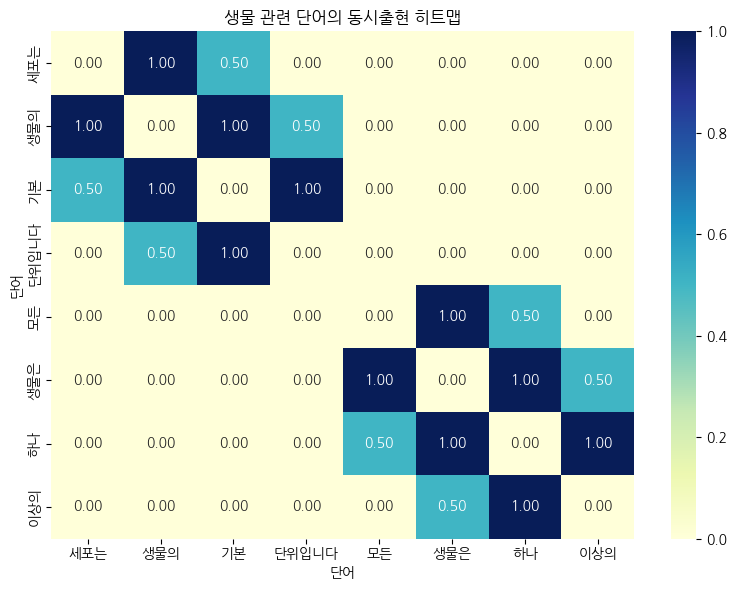


 생물 주제 통계:
  총 빈도: 134.00
  0이 아닌 원소 수: 174
  최대값: 1.00
  최소값: 0.50
  평균값: 0.77


In [11]:
tokenized_bio = preprocess_text(corpus_bio)
word_to_id_bio, id_to_word_bio, word_counts_bio = build_vocabulary(tokenized_bio)

matrix_bio = build_cooccurrence_matrix_custom_weight(tokenized_bio, word_to_id_bio, window_size=2, mode='default')

visualize_heatmap(matrix_bio, id_to_word_bio, top_n=8, title='생물 관련 단어의 동시출현 히트맵')
analyze_matrix(matrix_bio, '생물 주제')
